# Libraries

In [1]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MaxPooling2D, concatenate, Convolution2D, Activation
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import math
import logging

# Data loading and exploration

In [2]:
IMG_SHAPE  = 227
batch_size = 32
random_seed = 9

In [3]:
fpath = './Dataset'
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['closed', 'open'] 

No. of categories =  2


In [4]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')

            img_lst.append(np.array(img_array))

            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  2422 
No. of labels loaded =  2422
<class 'list'> <class 'list'>


In [5]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (2422, 227, 227, 3) 
Labels shape =  (2422,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


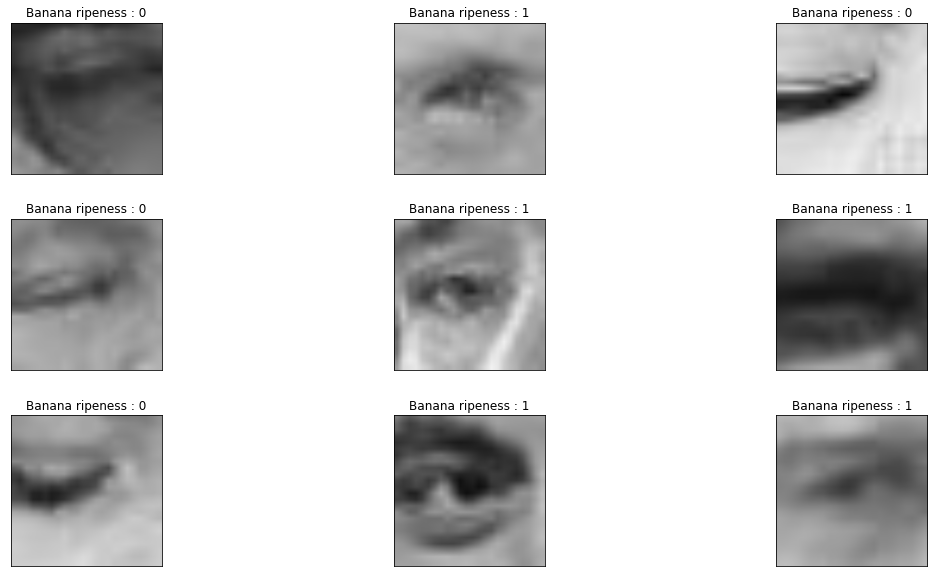

In [6]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Banana ripeness : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

# Prepare data for training the CNN model

In [7]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 2419 2420 2421]

'n' values after shuffling =  [ 737 2294  456 ...  501  348  382]


In [8]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (2422, 227, 227, 3) 
Labels shape after shuffling =  (2422,)


In [9]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (2422, 227, 227, 3)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (1879, 227, 227, 3)
y_train shape =  (1879,)

x_test shape =  (485, 227, 227, 3)
y_test shape =  (485,)

x_val shape =  (58, 227, 227, 3)
y_val shape =  (58,)


In [11]:
##One-hot-encode
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)

# Define CNN model

In [12]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [13]:
pre_trained_model = SqueezeNet(input_shape=x_train[0].shape, include_top=False, weights="imagenet")

In [14]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
conv1
relu_conv1
pool1
fire2/squeeze1x1
fire2/relu_squeeze1x1
fire2/expand1x1
fire2/expand3x3
fire2/relu_expand1x1
fire2/relu_expand3x3
fire2/concat
fire3/squeeze1x1
fire3/relu_squeeze1x1
fire3/expand1x1
fire3/expand3x3
fire3/relu_expand1x1
fire3/relu_expand3x3
fire3/concat
pool3
fire4/squeeze1x1
fire4/relu_squeeze1x1
fire4/expand1x1
fire4/expand3x3
fire4/relu_expand1x1
fire4/relu_expand3x3
fire4/concat
fire5/squeeze1x1
fire5/relu_squeeze1x1
fire5/expand1x1
fire5/expand3x3
fire5/relu_expand1x1
fire5/relu_expand3x3
fire5/concat
pool5
fire6/squeeze1x1
fire6/relu_squeeze1x1
fire6/expand1x1
fire6/expand3x3
fire6/relu_expand1x1
fire6/relu_expand3x3
fire6/concat
fire7/squeeze1x1
fire7/relu_squeeze1x1
fire7/expand1x1
fire7/expand3x3
fire7/relu_expand1x1
fire7/relu_expand3x3
fire7/concat
fire8/squeeze1x1
fire8/relu_squeeze1x1
fire8/expand1x1
fire8/expand3x3
fire8/relu_expand1x1
fire8/relu_expand3x3
fire8/concat
fire9/squeeze1x1
fire9/relu_squeeze1x1
fire9/expand1x1
fire9/expand3x3
fire

In [15]:
last_layer = pre_trained_model.get_layer('fire9/concat')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='sigmoid')(x)
model = tf.keras.Model(pre_trained_model.input, x)

# Train model

In [16]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 113, 113, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 relu_conv1 (Activation)        (None, 113, 113, 64  0           ['conv1[0][0]']                  
                                )                                                             

 on)                                                                                              
                                                                                                  
 fire5/concat (Concatenate)     (None, 27, 27, 256)  0           ['fire5/relu_expand1x1[0][0]',   
                                                                  'fire5/relu_expand3x3[0][0]']   
                                                                                                  
 pool5 (MaxPooling2D)           (None, 13, 13, 256)  0           ['fire5/concat[0][0]']           
                                                                                                  
 fire6/squeeze1x1 (Conv2D)      (None, 13, 13, 48)   12336       ['pool5[0][0]']                  
                                                                                                  
 fire6/relu_squeeze1x1 (Activat  (None, 13, 13, 48)  0           ['fire6/squeeze1x1[0][0]']       
 ion)     

                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 3)            1539        ['dropout[0][0]']                
                                                                                                  
Total params: 986,691
Trainable params: 264,195
Non-trainable params: 722,496
__________________________________________________________________________________________________


In [18]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [19]:
x_train.shape,y_train.shape

((1879, 227, 227, 3), (1879, 3))

In [20]:
start_time = time.time()

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

logging.basicConfig(filename="CNN-basedTL_SqueezeNet_log.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/50
58/58 [==============================] - 12s 193ms/step - loss: 2.3307 - acc: 0.4973 - val_loss: 0.6877 - val_acc: 0.6562
Epoch 2/50
58/58 [==============================] - 11s 188ms/step - loss: 0.8849 - acc: 0.5014 - val_loss: 0.6798 - val_acc: 0.5938
Epoch 3/50
58/58 [==============================] - 10s 173ms/step - loss: 0.7156 - acc: 0.4997 - val_loss: 0.6825 - val_acc: 0.5938
Epoch 4/50
58/58 [==============================] - 10s 172ms/step - loss: 0.6948 - acc: 0.5181 - val_loss: 0.6852 - val_acc: 0.5938
Epoch 5/50
58/58 [==============================] - 11s 185ms/step - loss: 0.6956 - acc: 0.5127 - val_loss: 0.7136 - val_acc: 0.4062
Epoch 6/50
58/58 [==============================] - 10s 176ms/step - loss: 0.6969 - acc: 0.5024 - val_loss: 0.6782 - val_acc: 0.5938
Epoch 7/50
58/58 [==============================] - 10s 177ms/step - loss: 0.6996 - acc: 0.5008 - val_loss: 0.7127 - val_acc: 0.4062
Epoch 8/50
58/58 [==============================] - 12s 201ms/step - 

In [21]:
model_json = model.to_json()
with open("SqueezeNet_Eyes_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("SqueezeNet_Eyes_Classifier.h5")
print("Saved model to disk")
model.save_weights("SqueezeNet_Eyes.h5")

Saved model to disk


# Evaluation model

In [22]:
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

16/16 [==============================] - 3s 163ms/step - loss: 0.6975 - acc: 0.4907
test_loss: 69.75
test_accuracy: 49.07


In [47]:
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
y_pred = model_probs
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 49.07
F1 score: 32.31
Precision: 24.08
Recall: 49.07


C:\Users\pined\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


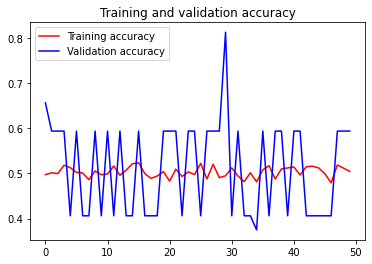

In [24]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TL.png")
plt.show() 

In [60]:
y_pred = model.predict(x_test)

16/16 [==============================] - 2s 137ms/step


In [61]:
y_pred.round()

array([[1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       ...,
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.]], dtype=float32)

In [70]:
confusion = confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion) 

Confusion Matrix

[[  0 247]
 [  0 238]]


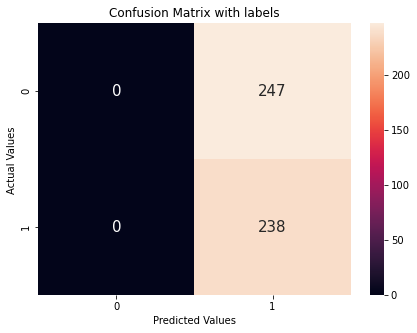

In [73]:
import seaborn as sns
plt.figure(figsize=(7, 5))
plt.xlabel("Preciccion")
plt.ylabel("Actual")
gf = sns.heatmap(confusion, annot=True,  annot_kws={'size': 15}, fmt = "d")
gf.set_title('Confusion Matrix with labels')
gf.set_xlabel('Predicted Values')
gf.set_ylabel('Actual Values ')
plt.show()